# Integrated Simulations

In [1]:
import os; from os import listdir; from os.path import isfile, join
import re  
from skimage.io import imread
from scipy import ndimage
import trackpy as tp
from cellpose import models
from cellpose import plot
from matplotlib import gridspec
import math
import seaborn as sn                       
from joblib import Parallel, delayed
import multiprocessing
from numpy import unravel_index
# To manipulate arrays
import numpy as np 
import random
from tqdm.notebook import tqdm
from timeit import default_timer as timer
import scipy
import pandas as pd
import shutil
import pathlib
import tifffile
import sys
from skimage.exposure import rescale_intensity
import rsnapsim as rss
# Plotting
import matplotlib as mpl ; import matplotlib.pyplot as plt 
# To create interactive elements
import ipywidgets as widgets ; from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout ; from IPython.display import Image

In [2]:
# Defining directories
current_dir = pathlib.Path().absolute()
sequences_dir = current_dir.parents[1].joinpath('DataBases','gene_files')
video_dir = current_dir.parents[1].joinpath('DataBases','moving_cells')
masks_dir = current_dir.parents[1].joinpath('DataBases','masks_for_sim_cell')
trajectories_dir = current_dir.parents[1].joinpath('DataBases','rsnapsim_simulations','kdm5b_ssa.npy')
rsnaped_dir = current_dir.parents[1].joinpath('rsnaped')
gene_file = current_dir.parents[1].joinpath('DataBases','gene_files','KDM5B_withTags.txt')

In [3]:
#import rsnaped as rsp
sys.path.append(str(rsnaped_dir))
import rsnaped as rsp
rsp.Banner(show=True).print_banner()

 
  ██████╗░░██████╗███╗░░██╗░█████╗░██████╗░███████╗██████╗░ 
  ██╔══██╗██╔════╝████╗░██║██╔══██╗██╔══██╗██╔════╝██╔══██╗ 
  ██████╔╝╚█████╗░██╔██╗██║███████║██████╔╝█████╗░░██║░░██║ 
  ██╔══██╗░╚═══██╗██║╚████║██╔══██║██╔═══╝░██╔══╝░░██║░░██║ 
  ██║░░██║██████╔╝██║░╚███║██║░░██║██║░░░░░███████╗██████╔╝ 
             by : L. Aguilera, T. Stasevich, and B. Munsky 


In [4]:
# List all video in dir
list_files_names = sorted([f for f in listdir(video_dir) if isfile(join(video_dir, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
path_files = [ str(video_dir.joinpath(f).resolve()) for f in list_files_names ] # creating the complete path for each file
path_files

['/home/luisub/Desktop/rsnaped/DataBases/moving_cells/MAX__1_MMStack_Pos1.ome.tif',
 '/home/luisub/Desktop/rsnaped/DataBases/moving_cells/MAX__1_MMStack_Pos4.ome.tif',
 '/home/luisub/Desktop/rsnaped/DataBases/moving_cells/MAX__1_MMStack_Pos6.ome.tif']

In [291]:
file_path = pathlib.Path(path_files[0])
video = imread(str(file_path)) 
img = np.expand_dims(video,axis=3)
image_optimization= np.concatenate((img,img),axis=3)

number_optimization_steps = 20

int_threshold_vector = np.round(np.linspace(0.1, 1.5, num=number_optimization_steps, endpoint=True,dtype=float),2)
cell_size_vector = np.linspace(60, 120, num=number_optimization_steps, endpoint=True,dtype=int)
model = models.Cellpose(gpu=True, model_type='nuclei') # model_type='cyto' or model_type='nuclei'
NUMBER_OF_CORES = np.min((2,multiprocessing.cpu_count()))
#NUMBER_OF_CORES = multiprocessing.cpu_count()

print(int_threshold_vector)
print(cell_size_vector)

[0.1  0.17 0.25 0.32 0.39 0.47 0.54 0.62 0.69 0.76 0.84 0.91 0.98 1.06
 1.13 1.21 1.28 1.35 1.43 1.5 ]
[ 60  63  66  69  72  75  78  82  85  88  91  94  97 101 104 107 110 113
 116 120]


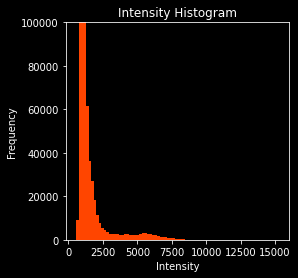

In [6]:
# Plotting the intensity distribution for a specific time point and an specific channel
plt.figure(figsize=(4,4))
plt.hist(image_optimization[0,:,:,0].flatten(), bins=80,color='orangered')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.ylim(0,1e5)
plt.title('Intensity Histogram')
plt.show()

In [7]:
def cells_center_of_mass(list_masks_for_all_frames):
    # Creating dataframe with centers of mass
    list_df=[]
    number_frames= list_masks_for_all_frames.shape[0]
    for i in range(number_frames):
        number_cells_in_frame = list_masks_for_all_frames[i].max()
        for m in range (1, number_cells_in_frame+1):
            selected_mask = np.where(list_masks_for_all_frames[i]==m,1,0) # Selecting only one mask.  
            x,y = ndimage.measurements.center_of_mass(selected_mask)
            list_df.append( [i,int(x),int(y)] )
            del x, y, selected_mask
    return np.array(list_df)

In [8]:
def convert_mask_labels (masks,tracking_dataframe):
    list_df=[]
    number_frames= masks.shape[0]
    list_new_masks= []
    for i in range(0,number_frames):
        # creating a copy of the original image
        temp_image = np.zeros_like(masks[0,:,:])
        trackpy_labels = tracking_dataframe.loc[tracking_dataframe['frame']==i ].particle.values
        # Iterate for each cell in 
        number_cells_in_frame = masks[i].max()
        for m in range (1, number_cells_in_frame+1):
            selected_mask = np.where(masks[i]==m,1,0) # Selecting only one mask.  
            for index, particle_label in enumerate (trackpy_labels):
                # Test if the center of mass is inside the selected mask 
                y, x = tracking_dataframe.loc[(tracking_dataframe['frame']==i ) & (tracking_dataframe['particle']==particle_label) , ['y', 'x']].values[0]
                if selected_mask[y,x]==1:
                    temp_image = np.where(selected_mask==1, particle_label,temp_image)
        list_new_masks.append(temp_image)
    return np.array(list_new_masks)

In [9]:
# def cell_segmentation_optimized (image_to_segment,model, intensity_percentile_threshold=99,cell_size=100,minimal_trajectory_length=5, memory_tracking=0,masks_with_trackpy_labels= False): 
#     # optimization code to detected cells using multiple intensity thresholds
#     image_test = image_to_segment.copy() # Making a copy of our img
#     image_test[image_test>np.percentile(image_test,intensity_percentile_threshold)]=np.percentile(image_test,intensity_percentile_threshold)  # threshold image values larger than 1000 equal to 1000
    
#     #image_test = image_to_segment.copy() 
#     #for indx in range(0,image_test.shape[0]):
#     #    tmp= image_test[indx,:,:,0]
#     #    tmp[tmp>np.percentile(tmp,intensity_percentile_threshold)]=np.percentile(tmp,intensity_percentile_threshold)  # threshold image values larger than 1000 equal to 1000
#     #    image_test[indx,:,:,0]= tmp
#     #image_test[:,:,:,1]= image_test[:,:,:,0]
    
#     #list_masks = []
#     #for index_cellpose in range(0,image_test.shape[0]):
#     #    masks, _, _, _ = model.eval(image_test[index_cellpose,:,:,:], diameter=cell_size, min_size=400, channels=[0,0], net_avg=False, augment=False,cellprob_threshold=0)
#     #    list_masks.append(masks)
#     #masks_for_all_frames = np.array(list_masks)
    
#     def segment(img):
#         mask, _, _, _ = model.eval(img, diameter=cell_size, min_size=400, channels=[0,0], net_avg=False, augment=False,cellprob_threshold=0)
#         return mask
#     list_masks = Parallel(n_jobs = NUMBER_OF_CORES)(delayed(segment)(image_test[index_cellpose,:,:,:]) for index_cellpose in range(0,image_test.shape[0]))
#     masks_for_all_frames = np.array(list_masks)
    
    
#     #masks_for_all_frames, _, _, _ = model.eval(image_test, diameter=cell_size, min_size=400, channels=[0,0], net_avg=False, augment=True,cellprob_threshold=-4, channel_axis=3,normalize=False)    
#     try:
#         array_center_mass = cells_center_of_mass(masks_for_all_frames)
#         df = pd.DataFrame(array_center_mass, columns=['frame', 'y', 'x'])
#         t = tp.link(df, memory=memory_tracking,search_range=100)
#         t_filtered = tp.filter_stubs(t, minimal_trajectory_length)  # selecting trajectories that appear in at least 10 frames.
#         num_detected_cells = t_filtered['particle'].nunique()
#         # reordering the index for the particles to have consecutive numbers
#         particle_index_trackpy_values = np.unique(t_filtered['particle'].values)
#         for idx, particle_number in enumerate(particle_index_trackpy_values):
#             t_filtered.loc[t_filtered['particle'] == particle_number, 'particle'] = -idx
#         t_filtered['particle'] = t_filtered['particle'].abs()
#     except:
#         num_detected_cells = 0
#         t_filtered = pd.DataFrame([], columns=['frame', 'y', 'x'])
#     if (masks_with_trackpy_labels == True) and (num_detected_cells>0) :
#         masks= convert_mask_labels (masks=masks_for_all_frames,tracking_dataframe=t_filtered)
#     else:
#         masks= masks_for_all_frames        
#     return num_detected_cells, masks, t_filtered, image_test

In [10]:
# Importing libraries with the watershed algorithm and local maximum detection
from scipy import ndimage as ndi              # Distance Transform
from skimage.feature import peak_local_max    # Local maxima in a matrix
from skimage.segmentation import watershed    # Watershed algorithm
from skimage.filters import gaussian # Module working with a gaussian filter
from skimage.draw import polygon
from skimage import measure

In [11]:
def watershed_segmentation(img,min_distance=50):
    mask_image = img.copy()
    mask_image = (mask_image/mask_image.max()) * 255
    #mask_image[mask_image>=threshold] =255    
    plt.imshow(mask_image)
    new_mask = gaussian(mask_image, sigma=4) # applying the gaussian filter
    contours = measure.find_contours(new_mask, level=100, fully_connected='high') # Finding the contours in the image    
    # Connecting the last and first  elements in the array (contours) to get a fully connected shape
    contours_connected = np.vstack((contours))
    contours_connected = np.vstack((contours_connected[-1,:],contours_connected))
    # make a new mask from the contours array
    watershed_starting_mask = np.zeros(img.shape).astype(int)                    # Prealocating an array with zeros. Notice the datatype.
    rr, cc = polygon(contours_connected[:,0], contours_connected[:,1])   # Returns the coordinates inside the contour
    watershed_starting_mask[rr,cc] = 1   
    #Computes the Distance Transform distance in the image
    distance = - ndi.distance_transform_edt(watershed_starting_mask)        
    # Apply watershed
    distance = ndi.distance_transform_edt(watershed_starting_mask)                       # Computes the Distance Transform distance in the image
    coords = peak_local_max(distance, min_distance=min_distance, labels=watershed_starting_mask)   # Use the Distance transform image to find local maxima
    _,inds = np.unique(distance[coords[:,0],coords[:,1]],return_index=True)      # Make sure they are unique
    coords = coords[inds,:]                                                      # Selecting unique indexes
    mask = np.zeros(distance.shape, dtype=bool)                                  # Prealocating an array with zeros
    mask[tuple(coords.T)] = True                                                 # Make an image with 1's where local maxima are
    markers, _ = ndi.label(mask)                                                 # Unique values used as the desired labels
    # Using the watershed algorithm
    labels = watershed(-distance, markers, mask=watershed_starting_mask, watershed_line=True)  

    return labels

In [12]:
# intensity_percentile_threshold = 95
# image_test = image_optimization.copy() # Making a copy of our img
# image_test[image_test>np.percentile(image_test,intensity_percentile_threshold)]=np.percentile(image_test,intensity_percentile_threshold)  # threshold image values larger than 1000 equal to 1000
# image_test = (image_test/image_test.max()) * 255
# labels = watershed_segmentation(image_test[10,:,:,1])
# plt.imshow(labels)

In [13]:
def cellpose_segmentation(img,cell_size,model,int_threshold_vector):
    mask, _, _, _ = model.eval(img, diameter=cell_size, min_size=2000, channels=[0,0], net_avg=False, augment=False,flow_threshold=int_threshold_vector)
    return mask

In [114]:
def cell_segmentation_optimized (image_to_segment,model, intensity_percentile_threshold=99,cell_size=100,minimal_trajectory_length=7, memory_tracking=0,masks_with_trackpy_labels= True,use_cellpose=True,min_distance=100): 
    # optimization code to detected cells using multiple intensity thresholds
    image_test = image_to_segment.copy() # Making a copy of our img
    #image_test[image_test>np.percentile(image_test,intensity_percentile_threshold)]=np.percentile(image_test,intensity_percentile_threshold)  # threshold image values larger than 1000 equal to 1000
    image_test[image_test>np.percentile(image_test,96)]=np.percentile(image_test,96)  # threshold image values larger than 1000 equal to 1000
    
    if use_cellpose == True:
        list_masks = Parallel(n_jobs = NUMBER_OF_CORES)(delayed(cellpose_segmentation)(image_test[index_cellpose,:,:,:],cell_size,model,intensity_percentile_threshold) for index_cellpose in range(0,image_test.shape[0]))
        masks_for_all_frames = np.array(list_masks)
    else:
        list_masks = Parallel(n_jobs = NUMBER_OF_CORES)(delayed(watershed_segmentation)(image_test[index_cellpose,:,:,0]) for index_cellpose in range(0,image_test.shape[0]))
        masks_for_all_frames = np.array(list_masks)
    try:
        mass_every_frame = np.count_nonzero(masks_for_all_frames, axis=0)
        array_center_mass = cells_center_of_mass(masks_for_all_frames)
        df = pd.DataFrame(array_center_mass, columns=['frame', 'y', 'x'])
        t = tp.link(df, memory=memory_tracking,search_range=80)
        t_filtered = tp.filter_stubs(t, minimal_trajectory_length)  # selecting trajectories that appear in at least 10 frames.
        num_detected_cells = t_filtered['particle'].nunique()-1 # removing the value for the empty cell
        
        # reordering the index for the particles to have consecutive numbers
        particle_index_trackpy_values = np.unique(t_filtered['particle'].values)
        for idx, particle_number in enumerate(particle_index_trackpy_values):
            t_filtered.loc[t_filtered['particle'] == particle_number, 'particle'] = -idx
        t_filtered['particle'] = t_filtered['particle'].abs()        
        trajectory_length =  np.array( [len(t_filtered.loc[t_filtered['particle'] == i, 'frame'].values) for i in range(t_filtered['particle'].nunique())] )
        metric =  np.mean(mass_every_frame) * np.sum(trajectory_length) * num_detected_cells
        #metric =  np.mean(mass_every_frame) * num_detected_cells
        print (num_detected_cells)
    except:
        num_detected_cells = 0
        t_filtered = pd.DataFrame([], columns=['frame', 'y', 'x'])
        metric = 0
        
    if (masks_with_trackpy_labels == True) and (num_detected_cells>0) :
        masks= convert_mask_labels (masks=masks_for_all_frames,tracking_dataframe=t_filtered)
    else:
        masks= masks_for_all_frames        
    return metric, masks, t_filtered, image_test,num_detected_cells

In [15]:
# Optimization code
detected_cells_matrix = np.zeros((int_threshold_vector.shape[0],cell_size_vector.shape[0] ) )
for index_intensity, intensity_value in enumerate(tqdm(int_threshold_vector)):
    for index_cell_size, cell_size in enumerate(cell_size_vector):
        detected_cells_matrix[index_intensity,index_cell_size],_,_,_,_ = cell_segmentation_optimized (image_to_segment=image_optimization, intensity_percentile_threshold=intensity_value,cell_size=cell_size,model=model)

  0%|          | 0/20 [00:00<?, ?it/s]

In [16]:
# detected_cells_matrix = np.zeros((int_threshold_vector.shape[0],) )
# for index_intensity, intensity_value in enumerate(tqdm(int_threshold_vector)):
#     detected_cells_matrix[index_intensity],_,_,_ = cell_segmentation_optimized (image_to_segment=image_optimization, model=model, intensity_percentile_threshold=intensity_value,use_cellpose=False)

In [35]:
# saving the numpy array
np.save('detected_cells_matrix.npy', detected_cells_matrix)
np.save('int_threshold_vector.npy', int_threshold_vector)
np.save('cell_size_vector.npy', cell_size_vector)

# loading the numpy array
#loaded_detected_cells_matrix = np.load('detected_cells_matrix.npy') 

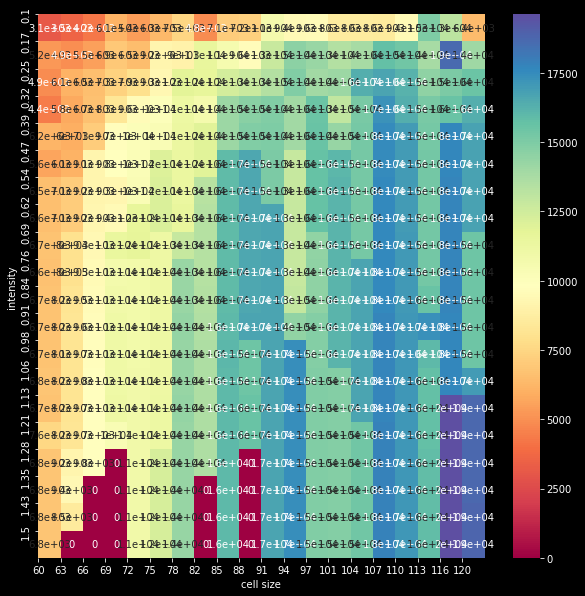

In [17]:
# showing optimization plot
tick_values= np.linspace(0, number_optimization_steps,num=number_optimization_steps,endpoint=False)
df_optimization = pd.DataFrame(detected_cells_matrix ) # Converting the image into a pandas data frame
fig, ax = plt.subplots(1,1,figsize=(10,10))
sn.heatmap(df_optimization, annot=True,cmap="Spectral",ax=ax)
ax.set_xlabel('cell size')
ax.set_ylabel('intensity')
ax.set_yticks(tick_values,int_threshold_vector)  
ax.set_xticks(tick_values,cell_size_vector)
plt.show()

In [115]:
# running for selected values
selected_intensity_index, selected_cell_size_index = unravel_index(detected_cells_matrix.argmax(), detected_cells_matrix.shape)
metric, masks_final, cell_movement_dataframe,image_optimization_selected,number_cells = cell_segmentation_optimized (image_to_segment=image_optimization, 
                                                                                                                intensity_percentile_threshold=int_threshold_vector[selected_intensity_index],
                                                                                                                cell_size=cell_size_vector[selected_cell_size_index], model=model ,
                                                                                                                masks_with_trackpy_labels= True)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
13


In [263]:
cell_movement_dataframe

,frame,y,x,particle
frame,,,,
0,0,132,395,0
0,0,495,517,1
0,0,639,391,2
0,0,651,679,3
0,0,688,467,4
...,...,...,...,...
54,54,479,486,1
54,54,408,244,6
54,54,333,979,12


In [265]:
np.unique(cell_movement_dataframe['particle'].values)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [116]:
print(int_threshold_vector[selected_intensity_index], cell_size_vector[selected_cell_size_index], int(metric), number_cells)

1.5 116 20803 13


In [63]:
#4142 189 15
# metric, masks_final, cell_movement_dataframe,image_optimization_selected, number_cells = cell_segmentation_optimized (image_to_segment=image_optimization, 
#                                                                                                                 intensity_percentile_threshold=1.5,
#                                                                                                                 cell_size=116, 
#                                                                                                                 model=model ,
#                                                                                                                 masks_with_trackpy_labels= True)
# print(int_threshold_vector[selected_intensity_index], cell_size_vector[selected_cell_size_index], metric, number_cells)

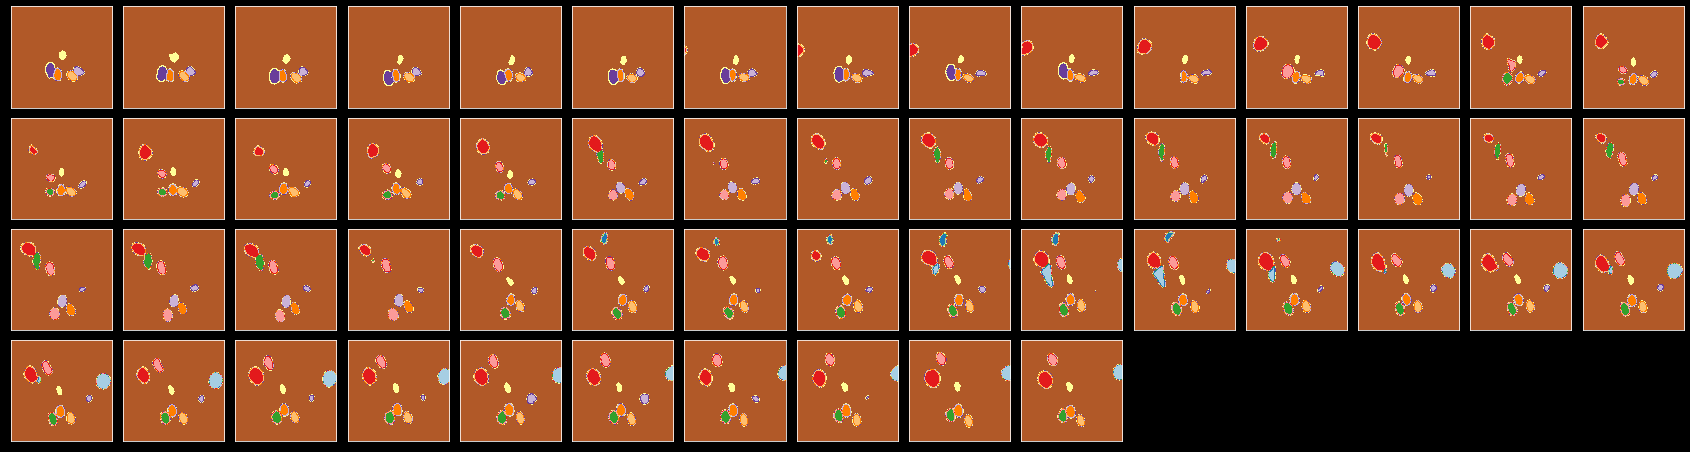

In [81]:
number_columns = 15
number_images = masks_final.shape[0]
number_rows = math.ceil(number_images/number_columns)
individual_figure_size = 2
# Loop to plot multiple cells in a grid
gs = gridspec.GridSpec(number_rows, number_columns)
gs.update(wspace = 0.1, hspace = 0.1) # set the spacing between axes.
fig = plt.figure(figsize = (individual_figure_size*number_columns, individual_figure_size*number_rows))
for index_image in range(0, number_images):
    ax = fig.add_subplot(gs[index_image])
    ax.imshow(masks_final[index_image], cmap = 'Paired_r',vmin=0,vmax=masks_final.max())
    ax.set_xticks([]); ax.set_yticks([])

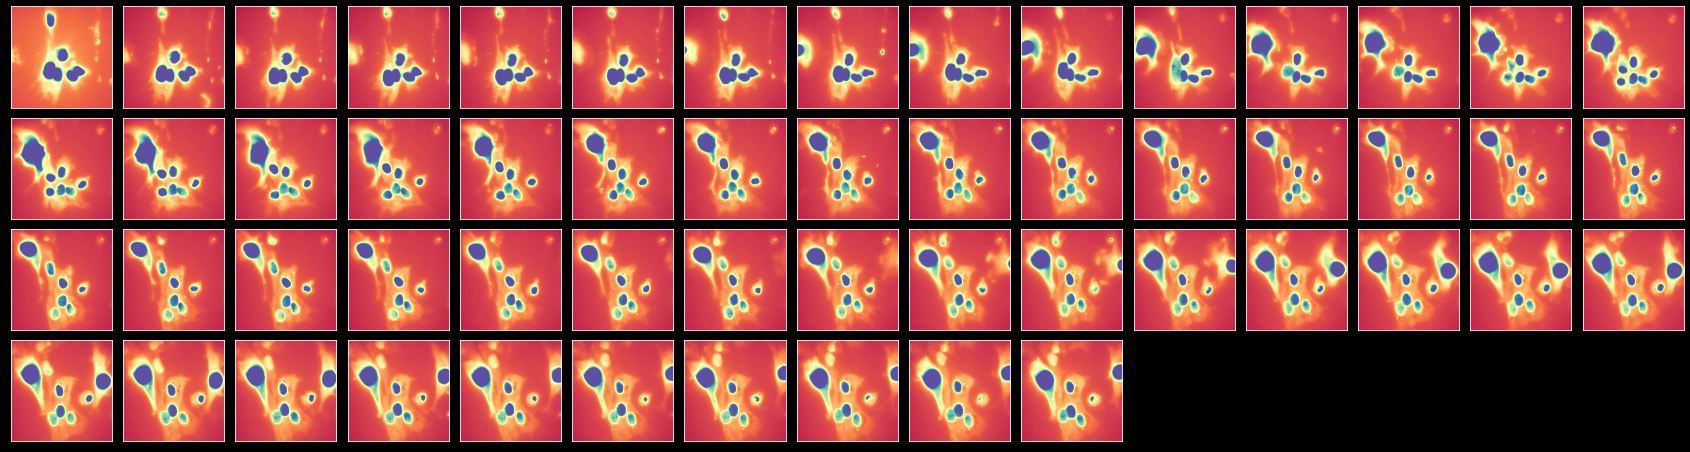

In [82]:
number_columns = 15
number_images = image_optimization_selected.shape[0]
number_rows = math.ceil(number_images/number_columns)
individual_figure_size = 2
# intensity

# Loop to plot multiple cells in a grid
gs = gridspec.GridSpec(number_rows, number_columns)
gs.update(wspace = 0.1, hspace = 0.1) # set the spacing between axes.
fig = plt.figure(figsize = (individual_figure_size*number_columns, individual_figure_size*number_rows))
for index_image in range(0, number_images):
    ax = fig.add_subplot(gs[index_image])
    ax.imshow(image_optimization_selected[index_image,:,:,0], cmap = 'Spectral',vmin=image_optimization_selected[:,:,:,0].min(),vmax=image_optimization_selected[:,:,:,0].max())
    ax.set_xticks([]); ax.set_yticks([])

### Plotting the spots in time

In [155]:
def plotting_masks(index_frame=0):
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    # plotting real image
    ax[0].imshow(image_optimization[index_frame,:,:,0], cmap = 'Spectral_r')
    ax[0].set_title('Frame '+ str(index_frame))
    ax[0].set_xticks([]); ax[0].set_yticks([])
    
    # plotting masks
    ax[1].imshow(masks_final[index_frame], cmap = 'tab20',vmin=0,vmax=masks_final.max())
    ax[1].set_title('Frame '+ str(index_frame))
    ax[1].set_xticks([]); ax[1].set_yticks([])
    plt.show()

In [156]:
index_frame = widgets.IntSlider(value=0, min=0,max=masks_final.shape[0]-1,step=1, description='Frame:')
widgets.interact(plotting_masks, index_frame=index_frame);

interactive(children=(IntSlider(value=0, description='Frame:', max=54), Output()), _dom_classes=('widget-inter…

## Detecting spots in the image

In [86]:
# Use filters to detect spots in cell
# perform particle tracking for ts
# plot ts trajectories (int, time)
# Save all outputs in a dataframe 

In [87]:
image_optimization.shape

(55, 1024, 1024, 2)

In [316]:
image_test=image_optimization[:,:,:,0].copy()
image_test[image_test>np.percentile(image_test,99)]=np.percentile(image_test,99)  # threshold image values larger than 1000 equal to 1000
filtered_img = rsp.Utilities.log_filter(image=image_test, sigma=1)
filtered_img.shape

(55, 1024, 1024)

In [317]:
def plotting_filtered_image(index_frame=0):
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    # plotting real image
    ax.imshow(filtered_img[index_frame], cmap = 'Spectral_r')
    ax.set_title('Frame '+ str(index_frame))
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

In [318]:
index_frame = widgets.IntSlider(value=0, min=0,max=masks_final.shape[0]-1,step=1, description='Frame:')
widgets.interact(plotting_filtered_image, index_frame=index_frame);

interactive(children=(IntSlider(value=0, description='Frame:', max=54), Output()), _dom_classes=('widget-inter…

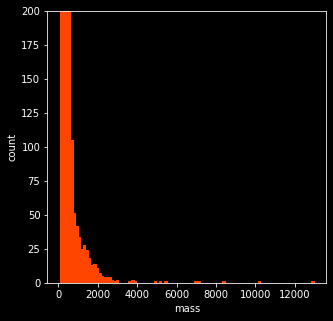

In [319]:
# This section generates an histograme with the intensity of the detected particles in the video.

particle_size = 7 # according to the documentation must be an odd number 3,5,7,9 etc.
minimal_intensity_for_selection = 0 # minimal intensity to detect a particle.

# "f" is a pandas data freame that contains the infomation about the detected spots
f = tp.locate(filtered_img[0,:,:], particle_size, minmass=minimal_intensity_for_selection) 

plt.rcParams["figure.figsize"] = (5,5)
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=100, color = "orangered", ec="orangered")
ax.set(xlabel='mass', ylabel='count');
ax.set_ylim([0,200])
plt.show()

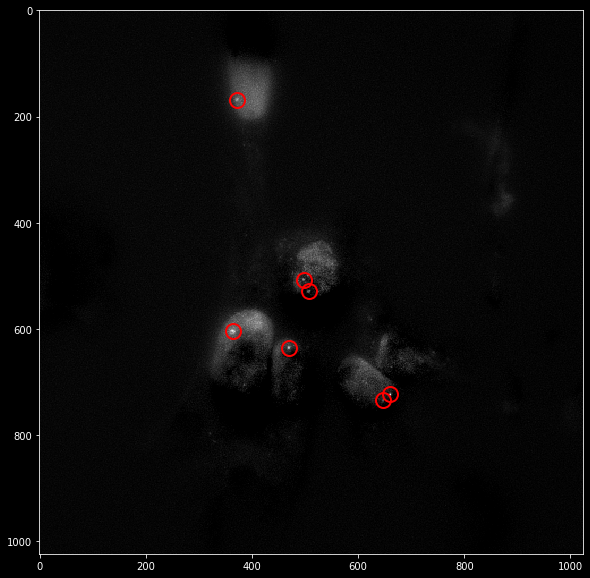

In [320]:
# This section generates an histogram with the intensity of the detected particles in the video.

particle_size = 7 # according to the documentation must be an odd number 3,5,7,9 etc.
minimal_intensity_for_selection = 5000 # minimal intensity to detect a particle.
# "f" is a pandas data frame that contains the information about the detected spots
fig, ax = plt.subplots(1,1,figsize=(10,10))

f = tp.locate(filtered_img[0,:,:], particle_size, minmass=minimal_intensity_for_selection,percentile=60) 
tp.annotate(f,filtered_img[0,:,:],ax=ax); 

In [321]:
# To start visualization move the time slider.
plt.rcParams["figure.figsize"] = (5,5) # if movie is too big, change size to (7,7)
def figure_viewer_tr(time,mass_text, particle_size):
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    ch = 0  
    f = tp.locate(filtered_img[time],particle_size, minmass=mass_text, maxsize=7, percentile=70) # "f" is a pandas data frame that contains the information about the detected spots
    tp.annotate(f,filtered_img[time],ax=ax) # tp.annotate is a trackpy function that displays the image with the detected spots  
values_size=[3,5,7,9] # Notice value must be an odd number.
interactive_plot_tr = interactive(figure_viewer_tr, mass_text = widgets.IntSlider(value=4000,min=1000,max=10000,description='min Intensity'), particle_size = widgets.IntSlider(min=3,max=11,step=2,value=7,description='Particle Size'), time = widgets.IntSlider(min=0,max=video.shape[0]-1,step=1,value=0,description='Time'))
controls = HBox(interactive_plot_tr.children[:-1], layout = Layout(flex_flow='row wrap'))
output = interactive_plot_tr.children[-1]
display(VBox([controls, output])) 

In [322]:
# This section saves the parameters adjusted in the previous widget in two variables that will be use for the rest of the code.
selected_intensity = interactive_plot_tr.kwargs_widgets[1].value
selected_size = interactive_plot_tr.kwargs_widgets[2].value

In [323]:
# "f" is a pandas data frame that contains the information about the detected spots.
# tp.batch is a trackpy function that detects spots for multiple frames in a video.
f = tp.batch(filtered_img,selected_size, minmass=selected_intensity,percentile=70)

In [324]:
f

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,168.480534,372.053967,5222.073896,1.863689,0.147940,370.517385,55181.0,0.001799,0
1,456.654481,549.887149,2323.962663,1.474776,0.186719,287.672561,24201.0,0.004104,0
2,467.825095,474.368987,2523.133977,1.501582,0.157621,288.651557,15772.0,0.006301,0
3,469.215322,527.149229,2080.649502,1.770923,0.104984,161.425577,41293.0,0.002404,0
4,469.893448,543.156145,2073.209132,1.630573,0.294889,222.558443,36788.0,0.002699,0
...,...,...,...,...,...,...,...,...,...
844,676.846241,474.210949,2523.333085,1.308799,0.140345,367.892702,6320.0,0.035749,54
845,678.447278,485.722730,2508.610685,1.392038,0.103367,330.725686,7129.0,0.031640,54
846,679.611409,499.653893,6167.021446,1.659247,0.209787,577.052925,22118.0,0.010109,54
847,809.204820,393.627836,2219.674778,1.610430,0.258231,227.950654,8093.0,0.027828,54


In [325]:
def spots_in_mask(f, masks):
    f_test=f.copy()
    f_test['Cell_ID'] = 0
    frames_in_dataframe = np.unique(f_test['frame'].values)
    for _, selected_frame in enumerate(frames_in_dataframe):
        selected_frame_masks= masks[selected_frame]
        selected_dataframe = f_test.loc[f_test['frame']==selected_frame]
        coords_int = np.array([selected_dataframe.y, selected_dataframe.x], dtype= int).T # These are the points detected by trackpy
        values_at_coords = selected_frame_masks[tuple(coords_int.T)] #
        f_test.loc[f_test['frame']==selected_frame ,'Cell_ID'] = values_at_coords.T # Check if pts are on/in polygon mask  
        del selected_frame_masks, selected_dataframe, coords_int, values_at_coords
    return f_test 

In [326]:
df_final = spots_in_mask(f, masks_final) 
df_final

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,Cell_ID
0,168.480534,372.053967,5222.073896,1.863689,0.147940,370.517385,55181.0,0.001799,0,0
1,456.654481,549.887149,2323.962663,1.474776,0.186719,287.672561,24201.0,0.004104,0,1
2,467.825095,474.368987,2523.133977,1.501582,0.157621,288.651557,15772.0,0.006301,0,1
3,469.215322,527.149229,2080.649502,1.770923,0.104984,161.425577,41293.0,0.002404,0,1
4,469.893448,543.156145,2073.209132,1.630573,0.294889,222.558443,36788.0,0.002699,0,1
...,...,...,...,...,...,...,...,...,...,...
844,676.846241,474.210949,2523.333085,1.308799,0.140345,367.892702,6320.0,0.035749,54,4
845,678.447278,485.722730,2508.610685,1.392038,0.103367,330.725686,7129.0,0.031640,54,4
846,679.611409,499.653893,6167.021446,1.659247,0.209787,577.052925,22118.0,0.010109,54,4
847,809.204820,393.627836,2219.674778,1.610430,0.258231,227.950654,8093.0,0.027828,54,8


In [327]:
df_final = df_final[df_final['Cell_ID']>0] # removing spots outside masks
df_final

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,Cell_ID
1,456.654481,549.887149,2323.962663,1.474776,0.186719,287.672561,24201.0,0.004104,0,1
2,467.825095,474.368987,2523.133977,1.501582,0.157621,288.651557,15772.0,0.006301,0,1
3,469.215322,527.149229,2080.649502,1.770923,0.104984,161.425577,41293.0,0.002404,0,1
4,469.893448,543.156145,2073.209132,1.630573,0.294889,222.558443,36788.0,0.002699,0,1
5,477.769427,551.401877,3611.864646,1.671460,0.253267,342.148254,38649.0,0.002569,0,1
...,...,...,...,...,...,...,...,...,...,...
844,676.846241,474.210949,2523.333085,1.308799,0.140345,367.892702,6320.0,0.035749,54,4
845,678.447278,485.722730,2508.610685,1.392038,0.103367,330.725686,7129.0,0.031640,54,4
846,679.611409,499.653893,6167.021446,1.659247,0.209787,577.052925,22118.0,0.010109,54,4
847,809.204820,393.627836,2219.674778,1.610430,0.258231,227.950654,8093.0,0.027828,54,8


In [378]:
cells_ids = np.unique(df_final['Cell_ID'].values)
list_df_cells =[]
for _, selected_cell in enumerate(cells_ids):
    df_selected_cell = df_final[df_final['Cell_ID']==selected_cell] # removing spots outside masks
    linked_dataframe = tp.link(df_selected_cell,search_range=50, memory=1)
    filtered_dataframe = tp.filter_stubs(linked_dataframe, 10)
    if len(filtered_dataframe)>0:
        list_df_cells.append(filtered_dataframe ) # selecting trajectories that appear in at least 10 frames.
    del linked_dataframe, df_selected_cell

In [380]:
dfp = pd.DataFrame(data = None, columns= df_final.columns)
dfp = pd.concat(list_df_cells)

In [381]:
dfp

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,Cell_ID,particle
frame,,,,,,,,,,,
0,523.160037,532.992567,2526.049210,1.821799,0.326598,218.555437,23673.0,0.004196,0,1,2
1,552.712921,509.801328,7063.044766,1.724477,0.183802,594.717856,41304.0,0.000159,1,1,2
2,569.695104,507.326377,10017.433089,1.860867,0.117024,664.135474,61439.0,0.000261,2,1,2
3,579.236919,507.181963,10140.754536,1.958310,0.084025,558.918977,60674.0,0.000465,3,1,2
4,585.724203,505.351535,11392.263981,1.902372,0.173337,683.381925,61770.0,0.000372,4,1,2
...,...,...,...,...,...,...,...,...,...,...,...
54,483.722009,216.024549,3613.283787,1.896792,0.260291,245.068086,48596.0,0.004591,54,6,41
54,479.554708,266.817127,2340.210026,1.816457,0.330071,212.832017,66935.0,0.003331,54,6,60
54,472.744711,275.804413,2581.474238,1.790059,0.341565,236.298044,68309.0,0.003264,54,6,61


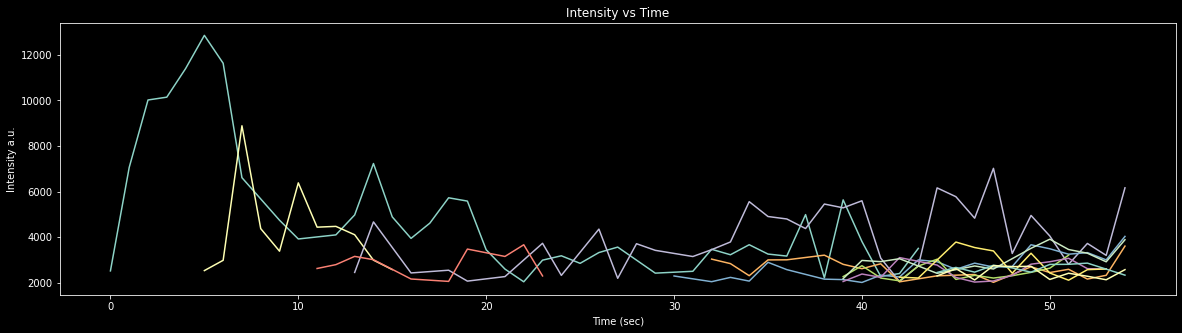

In [382]:
# Defining the number of detected spots.
n_particles = dfp['particle'].nunique()

# Plotting
plt.figure(figsize=(20,5))

# plotting intensities in au
for id in range(0,n_particles):
    plt.plot(dfp.loc[dfp['particle']==dfp['particle'].unique()[id]].frame, dfp.loc[dfp['particle']==dfp['particle'].unique()[id]].mass )
plt.xlabel('Time (sec)')
plt.ylabel('Intensity a.u.')
plt.title('Intensity vs Time')
plt.show()

In [ ]:
# Plotting for each cell

<AxesSubplot:>

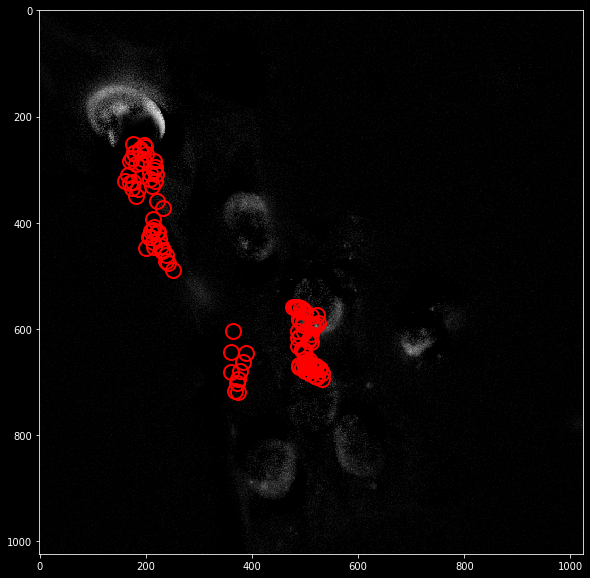

In [376]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ch = 0  
time =30
tp.annotate(dfp,filtered_img[time],ax=ax)